<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: MIRI view outlier_detection

<span style="color:red"> **Instruments Affected**</span>: e.g., FGS, MIRI, NIRCam, NIRISS

### Table of Contents


<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests or Visualization](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This notebook allows visual inspection of a set of dithered images that are combined as part of calwebb_image3. The notebook will take a set of eight simulated images, starting with the uncal format files that are the output of MIRISim. These images will have a randomized location for about 50 point sources and no extended sources.

These data files will be processed through calwebb_detector1, calwebb_image2 and calwebb_image3 and the output *i2d data file will be inspected. Past versions of the pipeline had the background subtracted twice, so the background levels were strongly negative, and other versions have had the background pixels wrongly flagged by outlier_detection. This notebook is simply a visual inspection to be sure there is nothing obviously wrong with the output. While this notebook will look at the output of calwebb_image3 as a whole, the main task is to find where outlier_detection is incorrectly flagging pixels.

> Pipeline documentation: https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/main.html

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/outlier_detection

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

The outlier detection algorithm is defined in the confluence page listed here. It is used to reject outlier pixels found when comparing multiple dithered images together. Images are compared in overlapping regions and any pixel that seems to be an outlier (based on iterative sigma clipping) can be flagged and rejected from any combined set or mosaic of images.

> https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Outlier+Detection


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

Here are some of the terms that will be used in this notebook.

JWST: James Webb Space Telescope

MIRI: Mid-Infrafred Instrument

MIRISim: MIRI data simulator


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test takes a set of simulated images (at different dithered positions) and proceses them through all three stages of the Imager pipeline: calwebb_detector1, calwebb_image2, and calwebb_image3. The tests being run here look at the output of the full image3 pipeine (the combined i2d data), check that the source_catalog output catalog marks the locations of our point sources, and checks on the number of pixels that are flagged in the outlier_detection step to be sure that the step is not flagging too many pixels.

[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). The simulator created eight imaging mode files, two exposures each at four different dither positions, using the specified filter. There are approximately 50 point sources scattered through the images.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)
print(data_dir.name)

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592


<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* astropy visualization for viewing images
* jwst pipeline to get the pipeline stages being tested
* jwst.datamodels for building model for JWST Pipeline
* ci_watson tools to retrieve data from artifactory
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [2]:
from astropy.io import fits
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval, LinearStretch
from astropy import table
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

from ci_watson.artifactory_helpers import get_bigdata
import glob

from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
from jwst.datamodels import RampModel, ImageModel, dqflags

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import os


<a id="data_load"></a>
# Loading the Data

### Data for internal use: Artifactory method
Artifactory should be used for data that is for internal use only.

The MIRISim data and any needed reference files to use with this simulated data are stored in artifactory.

[Top of Page](#title_ID)

In [3]:
print("Downloading input file 1")
input_file1 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits')
print("Downloading input file 2")
input_file2 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits')
print("Downloading input file 3")
input_file3 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits')
print("Downloading input file 4")
input_file4 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits')
print("Downloading input file 5")
input_file5 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits')
print("Downloading input file 6")
input_file6 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits')
print("Downloading input file 7")
input_file7 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits')
print("Downloading input file 8")
input_file8 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits')

#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')


print("Finished Downloads")
input_files=[input_file1,input_file2,input_file3,input_file4,input_file5,input_file6,input_file7,input_file8]

Finished Downloads


<a id="pipeline"></a>
# Run the Steps or Pipeline

The sections below will run the data through multiple pipeline steps.

[Top of Page](#title_ID)

In [4]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

print('There are ', len(input_files), ' images.')
    
# set up pipeline parameters for input
pipe1 = Detector1Pipeline()
pipe1.jump.rejection_threshold = rej_thresh
pipe1.jump.override_readnoise = readnoise
pipe1.ramp_fit.override_readnoise = readnoise

pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
    
slopelist = []    
    
# loop over list of files
for file in input_files:
       
    # set up output file name
    base, remainder = file.split('.')
    outname = base
        
    pipe1.jump.output_file = outname+'.fits'    
    #pipe1.ramp_fit.output_file = outname+'.fits'
    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
    rampfile = pipe1.run(file)
    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

print('Detector 1 steps completed on all files.')
print(slopelist)

2021-02-24 15:58:42,292 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-02-24 15:58:42,293 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-02-24 15:58:42,294 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-02-24 15:58:42,295 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-02-24 15:58:42,296 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-02-24 15:58:42,297 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-02-24 15:58:42,299 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-02-24 15:58:42,300 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-02-24 15:58:42,301 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-02-24 15:58:42,302 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-02-24 15:58:42,303 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-02-24 15:58:42,304 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-02-24 15:58:42,305 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-02-24 15:58:42,306 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-02-24 15:58:42,307 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-02-24 15:58:42,308 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-02-24 15:58:42,310 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-02-24 15:58:42,479 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits',).


There are  8  images.


2021-02-24 15:58:42,488 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-02-24 15:58:43,200 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 15:58:44,507 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 15:58:44,508 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 15:58:44,509 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 15:58:44,510 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 15:58:44,511 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 15:58:44,512 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 15:58:44,512 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 15:58:44,513 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 15:58:44,514 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 15:58:44,515 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 15:58:44,516 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 15:58:44,516 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 15:58:44,516 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 15:58:44,517 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 15:58:45,051 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:45,053 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:45,060 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 15:58:45,060 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 15:58:45,061 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 15:58:45,114 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:45,115 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:45,125 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 15:58:45,665 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 15:58:45,743 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:45,744 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:45,753 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 15:58:46,877 - stpipe.Detector1Pipeline.saturation - INFO - Detected 325 saturated pixels


2021-02-24 15:58:46,945 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 15:58:46,948 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 15:58:47,067 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:47,068 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:47,078 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 15:58:49,065 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 15:58:49,185 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:49,186 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:49,758 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 15:58:49,876 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:49,877 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:50,370 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 15:58:50,484 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:50,485 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:50,496 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 15:58:50,598 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 15:58:51,192 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 15:58:51,322 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:51,323 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:58:51,333 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 15:58:52,677 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 15:58:52,794 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:52,795 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 15:58:52,807 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 15:58:53,329 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 15:58:53,454 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:53,455 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 15:58:53,465 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 15:58:55,020 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 15:58:55,021 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 15:58:56,366 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 15:58:56,664 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:56,665 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 15:58:56,666 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 15:58:56,667 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 15:58:56,740 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 15:58:56,742 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 15:58:56,748 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 15:58:56,753 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 15:58:56,764 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 15:58:56,774 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 15:58:57,509 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 15:58:58,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 15:58:59,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3302 pixels with at least one CR


2021-02-24 15:58:59,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 15:59:01,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2601 pixels with at least one CR


2021-02-24 15:59:01,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 15:59:02,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2740 pixels with at least one CR


2021-02-24 15:59:02,570 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.0604 sec


2021-02-24 15:59:02,572 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.823341


2021-02-24 15:59:03,007 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits


2021-02-24 15:59:03,007 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 15:59:03,135 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 15:59:03,136 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 15:59:03,147 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 15:59:03,157 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 15:59:03,166 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 15:59:03,167 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 15:59:03,367 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 15:59:03,368 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 15:59:10,203 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:11,603 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:12,960 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:22,659 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:23,096 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:28,738 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:30,134 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:31,023 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:40,803 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:41,233 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:46,899 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:48,294 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:49,196 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 15:59:49,647 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 15:59:50,696 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 15:59:51,680 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 15:59:52,758 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 15:59:52,759 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 15:59:52,812 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 15:59:52,961 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 15:59:52,963 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:52,983 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 15:59:52,984 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 15:59:52,985 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 15:59:53,051 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 15:59:53,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:53,069 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 15:59:53,070 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 15:59:53,071 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 15:59:53,154 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rateints.fits


2021-02-24 15:59:53,155 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 15:59:53,200 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits


2021-02-24 15:59:53,201 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 15:59:53,291 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',).


2021-02-24 15:59:53,299 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 15:59:53,603 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 15:59:53,610 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 15:59:53,611 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 15:59:53,611 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 15:59:53,613 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 15:59:53,613 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 15:59:53,615 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 15:59:53,615 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 15:59:53,615 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 15:59:53,616 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 15:59:53,617 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 15:59:53,618 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 15:59:53,619 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 15:59:53,619 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 15:59:53,619 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 15:59:54,072 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:54,074 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:54,080 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 15:59:54,081 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 15:59:54,082 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 15:59:54,136 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:54,138 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:54,147 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 15:59:54,478 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 15:59:54,545 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:54,547 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:54,556 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 15:59:55,609 - stpipe.Detector1Pipeline.saturation - INFO - Detected 325 saturated pixels


2021-02-24 15:59:55,672 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 15:59:55,675 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 15:59:55,754 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:55,755 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:55,764 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 15:59:57,521 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 15:59:57,634 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:57,635 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:58,131 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 15:59:58,207 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:58,209 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:58,510 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 15:59:58,620 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:58,621 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:58,631 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 15:59:58,729 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 15:59:59,311 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 15:59:59,399 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 15:59:59,401 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 15:59:59,410 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:00:00,510 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:00:00,621 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:00:00,622 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:00:00,633 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:00:01,125 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:00:01,209 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:00:01,210 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:00:01,219 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:00:02,759 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:00:02,759 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:00:04,035 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:00:04,313 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:00:04,314 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:00:04,314 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:00:04,315 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:00:04,381 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:00:04,383 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:00:04,390 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:00:04,394 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:00:04,403 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:00:04,413 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:00:04,972 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:00:06,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:00:07,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3213 pixels with at least one CR


2021-02-24 16:00:07,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:00:08,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2895 pixels with at least one CR


2021-02-24 16:00:08,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:00:09,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2793 pixels with at least one CR


2021-02-24 16:00:10,017 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.04448 sec


2021-02-24 16:00:10,019 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.629005


2021-02-24 16:00:10,448 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits


2021-02-24 16:00:10,449 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:00:10,568 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:00:10,569 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:00:10,580 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:00:10,589 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:00:10,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:00:10,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:00:10,776 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:00:10,777 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:00:17,512 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:18,900 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:20,242 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:29,992 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:30,429 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:35,975 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:37,397 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:38,282 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:48,063 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:48,494 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:54,073 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:55,465 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:56,342 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:00:56,775 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:00:57,801 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:00:58,798 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:00:59,844 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:00:59,844 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:00:59,896 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:01:00,009 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:01:00,011 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:00,031 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:01:00,032 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:01:00,033 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:01:00,093 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:01:00,094 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:00,111 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:01:00,111 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:01:00,112 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:01:00,196 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rateints.fits


2021-02-24 16:01:00,197 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:01:00,242 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits


2021-02-24 16:01:00,242 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:01:00,362 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',).


2021-02-24 16:01:00,370 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:01:00,676 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:01:00,682 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:01:00,683 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:01:00,683 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:01:00,684 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:01:00,685 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:01:00,686 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:01:00,687 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:01:00,687 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:01:00,688 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:01:00,689 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:01:00,690 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:01:00,691 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:01:00,691 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:01:00,691 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:01:01,144 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:01,145 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:01,152 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:01:01,152 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:01:01,153 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:01:01,209 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:01,210 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:01,220 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:01:01,549 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:01:01,616 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:01,618 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:01,627 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:01:02,637 - stpipe.Detector1Pipeline.saturation - INFO - Detected 334 saturated pixels


2021-02-24 16:01:02,698 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:01:02,701 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:01:02,779 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:02,780 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:02,789 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:01:04,549 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:01:04,658 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:04,659 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:05,123 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:01:05,200 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:05,201 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:05,500 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:01:05,605 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:05,606 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:05,616 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:01:05,695 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:01:06,288 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:01:06,371 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:06,372 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:01:06,381 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:01:07,425 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:01:07,553 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:07,554 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:01:07,564 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:01:08,053 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:01:08,135 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:08,136 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:01:08,145 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:01:09,703 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:01:09,703 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:01:10,942 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:01:11,205 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:11,207 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:01:11,207 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:01:11,208 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:01:11,275 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:01:11,276 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:01:11,283 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:01:11,287 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:01:11,296 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:01:11,306 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:01:11,869 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:01:13,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:01:14,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3157 pixels with at least one CR


2021-02-24 16:01:14,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:01:15,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2806 pixels with at least one CR


2021-02-24 16:01:15,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:01:16,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2540 pixels with at least one CR


2021-02-24 16:01:16,897 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.02645 sec


2021-02-24 16:01:16,898 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.615296


2021-02-24 16:01:17,330 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits


2021-02-24 16:01:17,331 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:01:17,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:01:17,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:01:17,456 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:01:17,466 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:01:17,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:01:17,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:01:17,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:01:17,620 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:01:24,338 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:25,717 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:26,628 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:36,330 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:36,760 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:42,302 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:43,685 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:44,990 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:54,690 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:01:55,117 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:00,678 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:02,064 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:03,379 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:03,800 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:02:04,907 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:02:05,898 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:02:06,925 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:02:06,925 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:02:06,975 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:02:07,088 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:02:07,089 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:07,110 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:02:07,110 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:02:07,111 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:02:07,173 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:02:07,174 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:07,191 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:02:07,192 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:02:07,193 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:02:07,276 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rateints.fits


2021-02-24 16:02:07,277 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:02:07,322 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits


2021-02-24 16:02:07,323 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:02:07,442 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',).


2021-02-24 16:02:07,451 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:02:07,739 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:02:07,744 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:02:07,746 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:02:07,746 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:02:07,747 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:02:07,748 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:02:07,749 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:02:07,749 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:02:07,750 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:02:07,751 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:02:07,752 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:02:07,753 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:02:07,753 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:02:07,753 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:02:07,754 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:02:08,246 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:08,247 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:08,254 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:02:08,254 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:02:08,255 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:02:08,309 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:08,311 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:08,320 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:02:08,683 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:02:08,750 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:08,751 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:08,760 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:02:09,792 - stpipe.Detector1Pipeline.saturation - INFO - Detected 335 saturated pixels


2021-02-24 16:02:09,853 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:02:09,856 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:02:09,934 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:09,935 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:09,945 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:02:11,684 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:02:11,794 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:11,795 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:12,286 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:02:12,362 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:12,364 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:12,662 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:02:12,770 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:12,771 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:12,781 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:02:12,879 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:02:13,453 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:02:13,542 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:13,543 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:02:13,552 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:02:14,621 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:02:14,727 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:14,729 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:02:14,738 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:02:15,252 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:02:15,330 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:15,331 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:02:15,340 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:02:16,956 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:02:16,956 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:02:18,185 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:02:18,454 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:18,456 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:02:18,456 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:02:18,457 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:02:18,525 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:02:18,526 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:02:18,533 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:02:18,537 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:02:18,547 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:02:18,556 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:02:19,142 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:02:20,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:02:21,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3148 pixels with at least one CR


2021-02-24 16:02:21,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:02:22,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2836 pixels with at least one CR


2021-02-24 16:02:22,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:02:23,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2631 pixels with at least one CR


2021-02-24 16:02:24,087 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.94435 sec


2021-02-24 16:02:24,089 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.556039


2021-02-24 16:02:24,564 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits


2021-02-24 16:02:24,564 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:02:24,671 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:02:24,673 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:02:24,683 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:02:24,693 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:02:24,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:02:24,702 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:02:24,834 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:02:24,835 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:02:31,423 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:32,797 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:33,698 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:43,359 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:43,787 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:49,327 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:50,703 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:51,996 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:02:52,856 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:02,520 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:02,950 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:08,514 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:09,886 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:11,185 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:11,617 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:03:12,728 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:03:13,772 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:03:14,913 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:03:14,914 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:03:14,964 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:03:15,075 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:03:15,077 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:15,097 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:03:15,097 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:03:15,098 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:03:15,160 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:03:15,161 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:15,178 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:03:15,179 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:03:15,180 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:03:15,262 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rateints.fits


2021-02-24 16:03:15,262 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:03:15,307 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits


2021-02-24 16:03:15,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:03:15,429 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',).


2021-02-24 16:03:15,438 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:03:15,738 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:03:15,744 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:03:15,745 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:03:15,746 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:03:15,747 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:03:15,748 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:03:15,749 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:03:15,749 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:03:15,750 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:03:15,751 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:03:15,751 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:03:15,752 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:03:15,753 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:03:15,753 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:03:15,753 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:03:16,203 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:16,204 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:16,211 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:03:16,211 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:03:16,212 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:03:16,268 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:16,269 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:16,278 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:03:16,635 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:03:16,703 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:16,704 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:16,713 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:03:17,754 - stpipe.Detector1Pipeline.saturation - INFO - Detected 289 saturated pixels


2021-02-24 16:03:17,815 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:03:17,820 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:03:17,913 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:17,914 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:17,923 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:03:19,713 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:03:19,819 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:19,820 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:20,308 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:03:20,392 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:20,393 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:20,723 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:03:20,827 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:20,828 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:20,838 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:03:20,937 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:03:21,514 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:03:21,608 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:21,609 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:03:21,618 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:03:22,702 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:03:22,807 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:22,808 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:03:22,817 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:03:23,336 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:03:23,422 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:23,423 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:03:23,432 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:03:25,069 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:03:25,069 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:03:26,373 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:03:26,654 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:26,655 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:03:26,656 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:03:26,657 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:03:26,726 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:03:26,728 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:03:26,734 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:03:26,738 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:03:26,748 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:03:26,757 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:03:27,351 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:03:28,524 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:03:29,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2908 pixels with at least one CR


2021-02-24 16:03:29,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:03:30,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2427 pixels with at least one CR


2021-02-24 16:03:31,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:03:32,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2608 pixels with at least one CR


2021-02-24 16:03:32,277 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.92522 sec


2021-02-24 16:03:32,279 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.544339


2021-02-24 16:03:32,698 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits


2021-02-24 16:03:32,698 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:03:32,824 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:03:32,825 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:03:32,835 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:03:32,845 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:03:32,854 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:03:32,855 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:03:33,017 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:03:33,018 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:03:39,644 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:41,022 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:41,948 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:51,639 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:52,097 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:03:58,987 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:00,522 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:01,493 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:11,385 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:11,852 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:17,586 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:19,062 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:20,398 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:20,821 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:04:21,911 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:04:22,909 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:04:23,996 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:04:23,996 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:04:24,051 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:04:24,181 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:04:24,182 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:24,203 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:04:24,203 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:04:24,204 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:04:24,271 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:04:24,272 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:24,290 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:04:24,290 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:04:24,291 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:04:24,377 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rateints.fits


2021-02-24 16:04:24,378 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:04:24,423 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits


2021-02-24 16:04:24,424 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:04:24,544 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',).


2021-02-24 16:04:24,553 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:04:24,847 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:04:24,853 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:04:24,854 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:04:24,855 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:04:24,856 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:04:24,857 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:04:24,858 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:04:24,858 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:04:24,859 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:04:24,860 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:04:24,861 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:04:24,862 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:04:24,862 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:04:24,862 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:04:24,863 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:04:25,320 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:25,322 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:25,328 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:04:25,329 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:04:25,329 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:04:25,388 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:25,389 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:25,399 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:04:25,756 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:04:25,825 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:25,826 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:25,835 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:04:26,885 - stpipe.Detector1Pipeline.saturation - INFO - Detected 289 saturated pixels


2021-02-24 16:04:26,948 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:04:26,951 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:04:27,037 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:27,038 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:27,048 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:04:28,875 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:04:29,003 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:29,005 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:29,500 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:04:29,589 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:29,590 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:29,917 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:04:30,027 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:30,029 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:30,039 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:04:30,137 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:04:30,721 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:04:30,817 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:30,818 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:04:30,827 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:04:31,918 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:04:32,036 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:32,037 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:04:32,046 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:04:32,587 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:04:32,674 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:32,675 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:04:32,684 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:04:34,343 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:04:34,344 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:04:35,661 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:04:35,956 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:35,957 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:04:35,958 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:04:35,958 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:04:36,028 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:04:36,030 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:04:36,037 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:04:36,041 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:04:36,050 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:04:36,060 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:04:36,650 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:04:37,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:04:38,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3100 pixels with at least one CR


2021-02-24 16:04:39,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:04:40,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2355 pixels with at least one CR


2021-02-24 16:04:40,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:04:41,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2479 pixels with at least one CR


2021-02-24 16:04:41,706 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.05467 sec


2021-02-24 16:04:41,707 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.670585


2021-02-24 16:04:42,134 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits


2021-02-24 16:04:42,134 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:04:42,271 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:04:42,272 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:04:42,282 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:04:42,292 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:04:42,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:04:42,302 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:04:42,455 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:04:42,457 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:04:49,848 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:51,230 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:04:52,142 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:01,797 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:02,236 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:09,192 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:10,602 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:11,927 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:21,617 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:22,053 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:29,049 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:30,444 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:31,339 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:05:31,747 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:05:32,844 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:05:33,892 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:05:34,958 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:05:34,959 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:05:35,010 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:05:35,133 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:05:35,134 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:35,154 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:05:35,155 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:05:35,156 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:05:35,219 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:05:35,221 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:35,238 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:05:35,238 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:05:35,239 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:05:35,324 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rateints.fits


2021-02-24 16:05:35,325 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:05:35,371 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits


2021-02-24 16:05:35,372 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:05:35,501 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',).


2021-02-24 16:05:35,509 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:05:35,786 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:05:35,792 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:05:35,793 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:05:35,794 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:05:35,795 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:05:35,795 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:05:35,796 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:05:35,797 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:05:35,797 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:05:35,798 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:05:35,799 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:05:35,800 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:05:35,801 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:05:35,801 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:05:35,801 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:05:36,252 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:36,253 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:36,260 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:05:36,260 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:05:36,261 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:05:36,318 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:36,319 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:36,328 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:05:36,666 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:05:36,735 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:36,736 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:36,745 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:05:37,821 - stpipe.Detector1Pipeline.saturation - INFO - Detected 297 saturated pixels


2021-02-24 16:05:37,884 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:05:37,887 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:05:37,975 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:37,976 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:37,985 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:05:39,748 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:05:39,859 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:39,863 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:40,354 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:05:40,433 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:40,434 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:40,741 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:05:40,849 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:40,850 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:40,860 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:05:40,958 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:05:41,560 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:05:41,651 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:41,652 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:05:41,662 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:05:42,715 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:05:42,827 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:42,828 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:05:42,837 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:05:43,353 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:05:43,433 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:43,434 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:05:43,443 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:05:45,173 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:05:45,174 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:05:46,508 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:05:46,813 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:46,815 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:05:46,815 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:05:46,816 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:05:46,885 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-02-24 16:05:46,886 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:05:46,893 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:05:46,897 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:05:46,907 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:05:46,916 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:05:47,481 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:05:48,679 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:05:49,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2866 pixels with at least one CR


2021-02-24 16:05:49,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:05:50,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2461 pixels with at least one CR


2021-02-24 16:05:51,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:05:52,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2753 pixels with at least one CR


2021-02-24 16:05:52,454 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.97227 sec


2021-02-24 16:05:52,456 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.562263


2021-02-24 16:05:52,876 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits


2021-02-24 16:05:52,876 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:05:52,989 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:05:52,990 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:05:53,000 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:05:53,010 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:05:53,019 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:05:53,019 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:05:53,176 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:05:53,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:06:01,791 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:03,309 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:04,791 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:05,747 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:15,547 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:15,990 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:24,065 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:25,616 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:26,603 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:36,398 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:36,857 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:44,976 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:46,548 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:48,029 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:06:48,462 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:06:49,521 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:06:50,534 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:06:51,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:06:51,608 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:06:51,658 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:06:51,777 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:06:51,779 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:51,800 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:06:51,800 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:06:51,801 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:06:51,865 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-02-24 16:06:51,866 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:51,884 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:06:51,884 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:06:51,885 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:06:51,970 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rateints.fits


2021-02-24 16:06:51,971 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:06:52,017 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits


2021-02-24 16:06:52,017 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-24 16:06:52,147 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits',).


2021-02-24 16:06:52,156 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'rate', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}, 'dq

2021-02-24 16:06:52,432 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-24 16:06:52,438 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-02-24 16:06:52,439 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-02-24 16:06:52,440 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-02-24 16:06:52,441 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-02-24 16:06:52,442 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-02-24 16:06:52,443 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-24 16:06:52,443 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits'.


2021-02-24 16:06:52,443 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits'.


2021-02-24 16:06:52,444 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-02-24 16:06:52,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-02-24 16:06:52,446 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-24 16:06:52,446 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-24 16:06:52,447 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-24 16:06:52,447 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-24 16:06:52,907 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:52,908 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'group_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:52,915 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-24 16:06:52,916 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-24 16:06:52,916 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-24 16:06:52,974 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:52,976 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dq_init', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:52,985 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-02-24 16:06:53,315 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-24 16:06:53,385 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:53,386 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'saturation', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:53,396 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-02-24 16:06:54,538 - stpipe.Detector1Pipeline.saturation - INFO - Detected 299 saturated pixels


2021-02-24 16:06:54,626 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-24 16:06:54,629 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-24 16:06:54,707 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:54,709 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ipc', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:54,718 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-02-24 16:06:56,565 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-24 16:06:56,693 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:56,694 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'firstframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:57,260 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-24 16:06:57,338 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:57,339 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'lastframe', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:57,646 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-24 16:06:57,772 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:57,773 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'reset', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:57,783 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0042.fits


2021-02-24 16:06:57,881 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:06:58,620 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-24 16:06:58,710 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:58,712 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'linearity', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:06:58,721 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-02-24 16:06:59,781 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-24 16:06:59,921 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:06:59,923 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'rscd', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'type': 'baseline'}


2021-02-24 16:06:59,932 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-02-24 16:07:00,523 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-24 16:07:00,601 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:07:00,603 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'dark_current', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'dark_output': None}


2021-02-24 16:07:00,611 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-02-24 16:07:02,358 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-02-24 16:07:02,358 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-24 16:07:03,715 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-24 16:07:04,023 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:07:04,024 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'refpix', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-24 16:07:04,024 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-02-24 16:07:04,025 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-24 16:07:04,095 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-02-24 16:07:04,096 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'jump', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'rejection_threshold': 10.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-24 16:07:04,103 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-02-24 16:07:04,107 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:07:04,116 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:07:04,126 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-24 16:07:04,697 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-24 16:07:05,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-24 16:07:06,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2882 pixels with at least one CR


2021-02-24 16:07:07,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-24 16:07:08,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2623 pixels with at least one CR


2021-02-24 16:07:08,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-02-24 16:07:09,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2631 pixels with at least one CR


2021-02-24 16:07:09,879 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.18077 sec


2021-02-24 16:07:09,880 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.777413


2021-02-24 16:07:10,354 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits


2021-02-24 16:07:10,355 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-24 16:07:10,462 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:07:10,463 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'ramp_fit', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-24 16:07:10,474 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/jwst_mirisim_readnoise.fits


2021-02-24 16:07:10,483 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-02-24 16:07:10,492 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-24 16:07:10,493 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-24 16:07:10,651 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-24 16:07:10,652 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-24 16:07:19,739 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:21,341 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:22,420 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:32,278 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:32,763 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:41,007 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:42,601 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:43,647 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:53,585 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:07:54,044 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:08:02,229 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:08:03,790 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:08:04,802 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-24 16:08:05,254 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:08:06,371 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:08:07,507 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-24 16:08:08,640 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 25


2021-02-24 16:08:08,641 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-02-24 16:08:08,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-24 16:08:08,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:08:08,810 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:08:08,831 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:08:08,832 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:08:08,833 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:08:08,896 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-02-24 16:08:08,897 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592'}


2021-02-24 16:08:08,914 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-24 16:08:08,914 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-24 16:08:08,915 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-24 16:08:09,001 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rateints.fits


2021-02-24 16:08:09,002 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-24 16:08:09,048 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits


2021-02-24 16:08:09,048 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed on all files.
[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>]


In [5]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')
    

# create an object for the pipeline    
pipe2 = Image2Pipeline()

callist = []

# cycle through files
for rampfile in slopelist:
    filename = rampfile.meta.filename
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)


2021-02-24 16:08:09,053 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-02-24 16:08:09,060 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-02-24 16:08:09,061 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-02-24 16:08:09,062 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-02-24 16:08:09,063 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-02-24 16:08:09,065 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-02-24 16:08:09,066 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-02-24 16:08:09,198 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:09,202 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True,

2021-02-24 16:08:09,208 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:09,214 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:09,215 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:09,216 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:09,216 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:09,216 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:09,217 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:09,218 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:09,219 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:09,219 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:09,220 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:09,221 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:09,222 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:09,222 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:09,222 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:09,223 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:09,224 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:09,225 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:09,225 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:09,225 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:09,225 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:09,226 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


There are  8  images.


2021-02-24 16:08:09,252 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:09,253 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-02-24 16:08:09,327 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:09,328 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:09,400 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:09,438 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:09,441 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-02-24 16:08:09,441 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-02-24 16:08:09,441 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:09,478 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:09,522 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:09,593 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:09,594 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:10,129 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:10,129 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:10,130 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:10,136 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:10,209 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:10,213 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:10,287 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:10,289 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:10,299 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:10,300 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:10,349 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:10,349 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:10,350 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:10,350 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:10,376 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:10,376 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:10,377 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:10,382 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:10,454 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:10,455 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-02-24 16:08:10,469 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:11,117 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:11,521 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:11,522 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-02-24 16:08:11,576 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2021-02-24 16:08:11,577 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:11,577 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:11,578 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:11,686 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2021-02-24 16:08:11,686 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:11,764 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:11,767 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:11,774 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:11,776 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:11,777 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:11,778 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:11,778 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:11,778 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:11,779 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:11,780 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:11,780 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:11,781 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:11,781 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:11,782 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:11,782 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:11,783 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:11,783 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:11,783 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:11,784 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:11,784 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:11,784 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:11,785 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:11,785 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:11,785 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:11,786 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:11,786 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:11,786 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:11,811 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:11,811 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-02-24 16:08:11,886 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:11,887 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:11,948 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:11,980 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:11,983 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-02-24 16:08:11,983 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-02-24 16:08:11,983 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:12,014 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:12,059 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:12,132 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:12,133 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:12,185 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:12,185 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:12,186 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:12,192 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:12,264 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:12,268 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:12,345 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:12,347 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:12,358 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:12,358 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:12,409 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:12,409 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:12,410 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:12,410 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:12,430 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:12,431 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:12,431 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:12,436 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:12,510 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:12,511 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:12,526 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:13,164 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:13,567 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:13,569 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-02-24 16:08:13,624 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits


2021-02-24 16:08:13,624 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:13,625 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:13,625 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:13,734 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


2021-02-24 16:08:13,734 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:13,813 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:13,817 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:13,823 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:13,826 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:13,829 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:13,829 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:13,829 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:13,829 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:13,830 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:13,830 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:13,831 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:13,831 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:13,832 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:13,834 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:13,834 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:13,835 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:13,835 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:13,835 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:13,835 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:13,836 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:13,836 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:13,837 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:13,837 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:13,837 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:13,838 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:13,838 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:13,838 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:13,862 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:13,863 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-02-24 16:08:13,940 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:13,941 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:14,004 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:14,036 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:14,039 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-02-24 16:08:14,039 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-02-24 16:08:14,040 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:14,070 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:14,114 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:14,189 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:14,190 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:14,241 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:14,242 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:14,242 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:14,249 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:14,322 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:14,325 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:14,403 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:14,404 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:14,414 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:14,415 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:14,466 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:14,466 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:14,466 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:14,467 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:14,486 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:14,487 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:14,488 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:14,493 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:14,567 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:14,568 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:14,582 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:15,226 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:15,635 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:15,636 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-02-24 16:08:15,691 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2021-02-24 16:08:15,691 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:15,692 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:15,692 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:15,800 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2021-02-24 16:08:15,801 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:15,881 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:15,885 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:15,891 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:15,894 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:15,895 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:15,895 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:15,896 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:15,896 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:15,896 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:15,897 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:15,898 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:15,898 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:15,899 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:15,900 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:15,900 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:15,900 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:15,901 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:15,901 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:15,901 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:15,901 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:15,902 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:15,902 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:15,903 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:15,903 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:15,903 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:15,903 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:15,904 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:15,928 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:15,928 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-02-24 16:08:16,007 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:16,008 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:16,068 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:16,100 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:16,103 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-02-24 16:08:16,104 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-02-24 16:08:16,104 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:16,134 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:16,179 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:16,254 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:16,255 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:16,305 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:16,306 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:16,306 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:16,313 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:16,385 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:16,389 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:16,469 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:16,470 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:16,480 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:16,480 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:16,531 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:16,532 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:16,532 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:16,532 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:16,551 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:16,552 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:16,553 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:16,558 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:16,639 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:16,640 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:16,656 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:17,304 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:17,708 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:17,709 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-02-24 16:08:17,764 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2021-02-24 16:08:17,764 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:17,765 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:17,766 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:17,873 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2021-02-24 16:08:17,874 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:17,967 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:17,971 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:17,977 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:17,980 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:17,981 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:17,981 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:17,982 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:17,982 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:17,983 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:17,983 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:17,984 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:17,984 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:17,985 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:17,986 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:17,986 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:17,987 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:17,987 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:17,987 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:17,987 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:17,988 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:17,988 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:17,988 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:17,989 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:17,989 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:17,989 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:17,990 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:17,990 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:18,015 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:18,015 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-02-24 16:08:18,095 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:18,096 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:18,156 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:18,188 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:18,191 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-02-24 16:08:18,192 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-02-24 16:08:18,192 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:18,222 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:18,267 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:18,345 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:18,346 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:18,396 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:18,397 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:18,397 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:18,403 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:18,476 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:18,479 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:18,561 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:18,562 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:18,572 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:18,573 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:18,624 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:18,624 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:18,624 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:18,625 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:18,647 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:18,647 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:18,648 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:18,653 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:18,733 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:18,734 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:18,749 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:19,416 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:19,822 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:19,824 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-02-24 16:08:19,877 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2021-02-24 16:08:19,878 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:19,878 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:19,879 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:19,987 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2021-02-24 16:08:19,987 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:20,071 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:20,075 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:20,081 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:20,084 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:20,085 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:20,086 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:20,086 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:20,086 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:20,086 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:20,087 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:20,088 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:20,088 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:20,089 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:20,089 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:20,090 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:20,090 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:20,090 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:20,090 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:20,091 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:20,091 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:20,092 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:20,092 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:20,093 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:20,093 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:20,093 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:20,093 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:20,093 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:20,117 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:20,118 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-02-24 16:08:20,200 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:20,201 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:20,261 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:20,293 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:20,296 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-02-24 16:08:20,296 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-02-24 16:08:20,297 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:20,327 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:20,371 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:20,450 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:20,451 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:20,501 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:20,502 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:20,502 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:20,509 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:20,581 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:20,585 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:20,671 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:20,673 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:20,683 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:20,683 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:20,734 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:20,735 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:20,735 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:20,735 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:20,755 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:20,756 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:20,757 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:20,761 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:20,842 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:20,843 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:20,857 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:21,523 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:21,929 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:21,930 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-02-24 16:08:21,984 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits


2021-02-24 16:08:21,985 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:21,985 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:21,986 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:22,094 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits


2021-02-24 16:08:22,094 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:22,180 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:22,185 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:22,191 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:22,194 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:22,195 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:22,196 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:22,196 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:22,196 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:22,197 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:22,197 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:22,198 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:22,198 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:22,199 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:22,200 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:22,201 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:22,201 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:22,201 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:22,201 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:22,202 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:22,202 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:22,202 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:22,203 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:22,204 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:22,204 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:22,204 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:22,204 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:22,205 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:22,229 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:22,230 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-02-24 16:08:22,318 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:22,319 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:22,380 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:22,412 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:22,415 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-02-24 16:08:22,416 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-02-24 16:08:22,416 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:22,446 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:22,490 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:22,571 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:22,572 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:22,622 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:22,623 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:22,623 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:22,630 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:22,706 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:22,710 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:22,794 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:22,796 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:22,806 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:22,806 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:22,857 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:22,857 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:22,858 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:22,858 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:22,879 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:22,880 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:22,880 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:22,885 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:22,967 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-02-24 16:08:22,968 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:22,982 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:23,647 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:24,057 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:24,058 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-02-24 16:08:24,114 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2021-02-24 16:08:24,114 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:24,114 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-02-24 16:08:24,115 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:24,223 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2021-02-24 16:08:24,223 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-02-24 16:08:24,310 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:24,314 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpe4op2592/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2021-02-24 16:08:24,320 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-02-24 16:08:24,323 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-02-24 16:08:24,324 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-02-24 16:08:24,324 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-02-24 16:08:24,325 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-02-24 16:08:24,325 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-02-24 16:08:24,325 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-02-24 16:08:24,326 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:24,326 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-02-24 16:08:24,327 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-02-24 16:08:24,327 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0518.fits'.


2021-02-24 16:08:24,328 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-02-24 16:08:24,328 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-02-24 16:08:24,329 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-02-24 16:08:24,329 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-02-24 16:08:24,329 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-02-24 16:08:24,329 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-02-24 16:08:24,330 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-02-24 16:08:24,330 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits'.


2021-02-24 16:08:24,331 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-02-24 16:08:24,331 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-02-24 16:08:24,331 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-02-24 16:08:24,331 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-02-24 16:08:24,332 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-02-24 16:08:24,332 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-02-24 16:08:24,352 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:24,353 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-02-24 16:08:24,437 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:24,438 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-24 16:08:24,499 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-24 16:08:24,531 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:24,534 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-02-24 16:08:24,535 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-02-24 16:08:24,535 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-02-24 16:08:24,565 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-02-24 16:08:24,609 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-02-24 16:08:24,694 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:24,696 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-02-24 16:08:24,746 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:24,746 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:24,747 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:24,753 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-24 16:08:24,827 - stpipe.Image2Pipeline.flat_field - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:221: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flag_nonsci = np.bitwise_and(science.dq, dqflags.pixel['NON_SCIENCE']).astype(np.bool)



2021-02-24 16:08:24,830 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-02-24 16:08:24,917 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:24,918 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-02-24 16:08:24,928 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0044.fits


2021-02-24 16:08:24,928 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-02-24 16:08:24,979 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-02-24 16:08:24,980 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-02-24 16:08:24,980 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-02-24 16:08:24,980 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-02-24 16:08:25,000 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-02-24 16:08:25,001 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-02-24 16:08:25,001 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947


2021-02-24 16:08:25,006 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-02-24 16:08:25,089 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-02-24 16:08:25,090 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2021-02-24 16:08:25,105 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:08:25,768 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-02-24 16:08:26,172 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:08:26,173 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-02-24 16:08:26,227 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits


2021-02-24 16:08:26,228 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-02-24 16:08:26,228 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-02-24 16:08:26,229 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-02-24 16:08:26,336 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits


2021-02-24 16:08:26,336 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits>]]


### Create association table of data output from calwebb_image2.

The calwebb_image3 pipeline takes in an association table of a set of images which should be combined. The association table can also be used to specify a background image to be subtracted or a source catalog to be used within the pipeline (sourcecat is not typically used with MIRI).

In [6]:
# use asn_from_list to create association table
import glob
calfiles = glob.glob('starfield*_cal.fits')
asn = asn_from_list.asn_from_list(calfiles, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

2021-02-24 16:08:26,342 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



jwnoprogram-a3001_none_010_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_50star4ptdither_combined.fits with 8 members


### Run calwebb_image3 on the association table, setting any specific parameters.

In [7]:
# use association table created in previous step with calwebb_image3
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=3.762  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 250 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.source_catalog.kernel_fwhm = fwhm
pipe3.source_catalog.snr_threshold = snr
pipe3.skymatch.save_results = True
pipe3.outlier_detection.save_results = True
pipe3.resample.save_results = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3
pipe3.run('starfield_50star4ptdither_asnfile.json')    
print('Image 3 pipeline finished.')

2021-02-24 16:08:26,356 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-02-24 16:08:26,357 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-02-24 16:08:26,358 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-02-24 16:08:26,360 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-02-24 16:08:26,361 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-02-24 16:08:26,362 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-02-24 16:08:26,364 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-02-24 16:08:26,452 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-02-24 16:08:26,457 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 250, 'brightest

2021-02-24 16:08:26,536 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-02-24 16:08:26,545 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-02-24 16:08:26,546 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-02-24 16:08:26,547 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-02-24 16:08:26,548 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-02-24 16:08:27,261 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-02-24 16:08:27,263 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 250, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-02-24 16:08:27,473 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:27,541 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2021-02-24 16:08:27,733 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:27,800 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2021-02-24 16:08:27,970 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:28,038 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2021-02-24 16:08:28,218 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:28,288 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2021-02-24 16:08:28,470 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:28,539 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2021-02-24 16:08:28,719 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:28,788 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2021-02-24 16:08:28,961 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:29,030 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2021-02-24 16:08:29,211 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/tweakreg/tweakreg_catalog.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (dqflags.pixel['NON_SCIENCE'] & model.dq).astype(np.bool)



2021-02-24 16:08:29,279 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2021-02-24 16:08:29,289 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:29,290 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-02-24 16:08:29,290 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-02-24 16:08:29,313 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2021-02-24 16:08:29,314 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2021-02-24 16:08:29,335 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2021-02-24 16:08:29,336 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2021-02-24 16:08:29,358 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2021-02-24 16:08:29,359 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2021-02-24 16:08:29,381 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2021-02-24 16:08:29,381 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2021-02-24 16:08:29,404 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2021-02-24 16:08:29,404 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2021-02-24 16:08:29,427 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2021-02-24 16:08:29,427 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2021-02-24 16:08:29,450 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2021-02-24 16:08:29,450 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2021-02-24 16:08:29,472 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2021-02-24 16:08:29,473 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2021-02-24 16:08:29,473 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:29,473 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-24 16:08:29,474 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-02-24 16:08:29.473839


2021-02-24 16:08:29,474 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.1


2021-02-24 16:08:29,474 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-24 16:08:29,614 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2021-02-24 16:08:29,618 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-02-24 16:08:29,704 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:29,705 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2021-02-24 16:08:29,706 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:29,708 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2021-02-24 16:08:29,708 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -6.04071e-05  YSH: -5.47067e-06


2021-02-24 16:08:29,708 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:29,709 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000246101   FIT MAE: 0.000220937


2021-02-24 16:08:29,709 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 47 objects.


2021-02-24 16:08:29,736 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/wcs.py:1990: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2021-02-24 16:08:29,745 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-02-24 16:08:29,833 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:29,834 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2021-02-24 16:08:29,834 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:29,836 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2021-02-24 16:08:29,836 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000206563  YSH: -0.000333784


2021-02-24 16:08:29,837 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:29,837 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00473526   FIT MAE: 0.0040427


2021-02-24 16:08:29,837 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-02-24 16:08:29,872 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-02-24 16:08:29,958 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:29,959 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2021-02-24 16:08:29,960 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:29,962 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2021-02-24 16:08:29,962 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000206458  YSH: -0.000336101


2021-02-24 16:08:29,962 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:29,963 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00474492   FIT MAE: 0.00407057


2021-02-24 16:08:29,963 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-02-24 16:08:29,998 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-02-24 16:08:30,214 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:30,216 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2021-02-24 16:08:30,216 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:30,218 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2021-02-24 16:08:30,218 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000142039  YSH: 0.000972143


2021-02-24 16:08:30,219 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:30,219 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0071248   FIT MAE: 0.00617708


2021-02-24 16:08:30,219 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-02-24 16:08:30,253 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-02-24 16:08:30,341 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:30,342 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2021-02-24 16:08:30,342 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:30,344 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2021-02-24 16:08:30,345 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000123982  YSH: 0.000994053


2021-02-24 16:08:30,345 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:30,345 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00711663   FIT MAE: 0.00616519


2021-02-24 16:08:30,345 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-02-24 16:08:30,379 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-02-24 16:08:30,467 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:30,468 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2021-02-24 16:08:30,469 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:30,470 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2021-02-24 16:08:30,471 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.00013952  YSH: 0.00262783


2021-02-24 16:08:30,471 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:30,471 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0111931   FIT MAE: 0.0066205


2021-02-24 16:08:30,472 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-02-24 16:08:30,505 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-02-24 16:08:30,593 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-02-24 16:08:30,594 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2021-02-24 16:08:30,595 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-02-24 16:08:30,596 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2021-02-24 16:08:30,597 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000153256  YSH: 0.00262958


2021-02-24 16:08:30,597 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-02-24 16:08:30,597 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0112073   FIT MAE: 0.00664904


2021-02-24 16:08:30,598 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-02-24 16:08:30,632 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-24 16:08:30,633 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-02-24 16:08:30.632636


2021-02-24 16:08:30,633 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.158797


2021-02-24 16:08:30,633 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-02-24 16:08:30,790 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-02-24 16:08:30,927 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-02-24 16:08:30,929 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-02-24 16:08:30,936 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:125: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.mask = np.asanyarray(mask, dtype=np.bool)



2021-02-24 16:08:30,936 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:257: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xs = np.linspace(-0.5, nx - 0.5, nintx, dtype=np.float)



2021-02-24 16:08:30,937 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:258: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ys = np.linspace(-0.5, ny - 0.5, ninty, dtype=np.float)[1:-1]



2021-02-24 16:08:30,937 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:264: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  borderx = np.empty((npts + 1,), dtype=np.float)



2021-02-24 16:08:30,938 - stpipe.Image3Pipeline.skymatch - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/skymatch/skyimage.py:265: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bordery = np.empty((npts + 1,), dtype=np.float)



2021-02-24 16:08:30,982 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:30,982 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-02-24 16:08:30.982283


2021-02-24 16:08:30,982 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:30,983 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-02-24 16:08:30,983 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-02-24 16:08:30,983 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-02-24 16:08:30,984 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:30,984 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-02-24 16:08:38,078 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0167706


2021-02-24 16:08:38,078 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0180527


2021-02-24 16:08:38,079 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0123383


2021-02-24 16:08:38,079 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0117159


2021-02-24 16:08:38,079 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-02-24 16:08:38,080 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0138662


2021-02-24 16:08:38,080 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0131553


2021-02-24 16:08:38,080 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00828195


2021-02-24 16:08:38,081 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:38,081 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-02-24 16:08:38,229 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:38,229 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.450178943460234 [not converted]


2021-02-24 16:08:38,230 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:38,230 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-02-24 16:08:38,230 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.4669 (old=0.0167706, delta=10.4502)


2021-02-24 16:08:38,230 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.4682 (old=0.0180527, delta=10.4502)


2021-02-24 16:08:38,231 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.4625 (old=0.0123383, delta=10.4502)


2021-02-24 16:08:38,231 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.4619 (old=0.0117159, delta=10.4502)


2021-02-24 16:08:38,231 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.4502 (old=0, delta=10.4502)


2021-02-24 16:08:38,232 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.464 (old=0.0138662, delta=10.4502)


2021-02-24 16:08:38,232 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.4633 (old=0.0131553, delta=10.4502)


2021-02-24 16:08:38,233 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.4585 (old=0.00828195, delta=10.4502)


2021-02-24 16:08:38,233 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:38,233 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-02-24 16:08:38.233528


2021-02-24 16:08:38,234 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:07.251245


2021-02-24 16:08:38,234 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-02-24 16:08:38,441 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_0_skymatch.fits


2021-02-24 16:08:38,652 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_1_skymatch.fits


2021-02-24 16:08:38,860 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_2_skymatch.fits


2021-02-24 16:08:39,067 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_3_skymatch.fits


2021-02-24 16:08:39,273 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_4_skymatch.fits


2021-02-24 16:08:39,481 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_5_skymatch.fits


2021-02-24 16:08:39,687 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_6_skymatch.fits


2021-02-24 16:08:39,899 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_7_skymatch.fits


2021-02-24 16:08:39,899 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-02-24 16:08:40,182 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-02-24 16:08:40,184 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'exptime', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '4.0 3.0', 'scale': '0.5 0.4', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-02-24 16:08:40,186 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2021-02-24 16:08:40,919 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:42,114 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:43,310 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:44,509 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:45,839 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:47,076 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:48,271 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:49,472 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:08:50,332 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 8 images


2021-02-24 16:08:50,751 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



2021-02-24 16:08:50,898 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-02-24 16:08:51,492 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:52,371 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:53,261 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:54,136 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:55,195 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:56,215 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:57,057 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:57,932 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-02-24 16:08:58,152 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:424: RuntimeWarning: overflow encountered in square
  ta = np.sqrt(np.abs(blot_data) + err_data ** 2)



2021-02-24 16:08:59,582 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_0_a3001_crf.fits


2021-02-24 16:08:59,776 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_1_a3001_crf.fits


2021-02-24 16:08:59,969 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_2_a3001_crf.fits


2021-02-24 16:09:00,160 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_3_a3001_crf.fits


2021-02-24 16:09:00,364 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_4_a3001_crf.fits


2021-02-24 16:09:00,557 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_5_a3001_crf.fits


2021-02-24 16:09:00,772 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_6_a3001_crf.fits


2021-02-24 16:09:00,983 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_7_a3001_crf.fits


2021-02-24 16:09:00,984 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-02-24 16:09:01,365 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-02-24 16:09:01,366 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-02-24 16:09:01,372 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-02-24 16:09:01,498 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-02-24 16:09:02,528 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:03,695 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:04,852 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:06,019 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:07,190 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:08,370 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:09,516 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:10,672 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-02-24 16:09:11,081 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-24 16:09:11,083 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021512981 -0.020377295 0.024586134 0.014642002 359.990548112 0.017629042 359.987474958 -0.017390255


2021-02-24 16:09:11,409 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-02-24 16:09:11,410 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-02-24 16:09:11,570 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-02-24 16:09:11,572 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 3.762, 'snr_threshold': 250, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-02-24 16:09:11,583 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-02-24 16:09:11,585 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-02-24 16:09:11,585 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-02-24 16:09:11,585 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-02-24 16:09:11,586 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-02-24 16:09:11,586 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-02-24 16:09:11,610 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-02-24 16:09:12,234 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 46 sources


2021-02-24 16:09:12,892 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-02-24 16:09:12,893 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-02-24 16:09:12,894 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


<a id="testing"></a>
# Perform Tests or Visualization

View the image and check number of pixels being flagged as outliers. 

[Top of Page](#title_ID)

2021-02-24 16:09:12,899 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-02-24 16:09:13,040 - stpipe - WARNING - <ipython-input-1-9da3ff6c8ad9>:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-5, vmax=4)



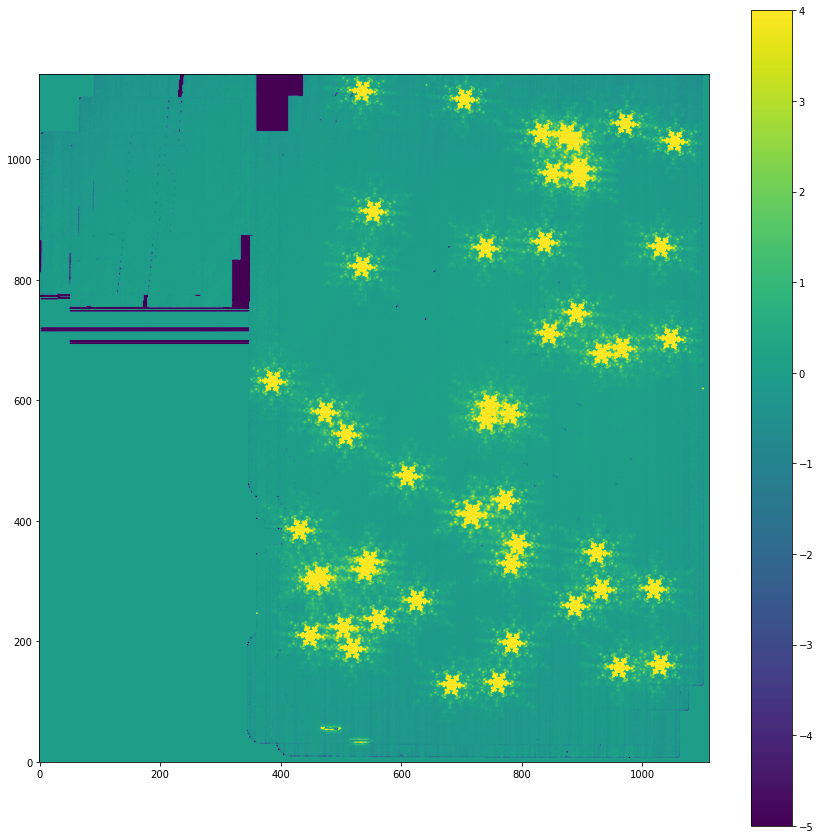

In [8]:
# read in i2d file

im_i2d = ImageModel('starfield_50star4ptdither_combined_i2d.fits')

viz1 = LogStretch()
viz2 = LogStretch() + ManualInterval(-5,5)
norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(15,15))
#plt.imshow(viz2(im_i2d.data),cmap='gray')
plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-5, vmax=4)
plt.colorbar()

### Image examination
The image output should have the Four Quadrant phase masks on the left of the image masked out (values of 0). The image area should be smooth in the background regions with multiple point sources bright against the background. Passing criteria for the Lyot mask region are still being determined.

## Check output of source catalog against image

In [9]:
photfile = 'starfield_50star4ptdither_combined_cat.ecsv'
data = table.Table.read(photfile, format='ascii', comment='#')
print(len(data),' sources detected')

2021-02-24 16:09:13,454 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



46  sources detected


2021-02-24 16:09:13,541 - stpipe - WARNING - <ipython-input-1-835b389b3e3b>:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-12, vmax=100)



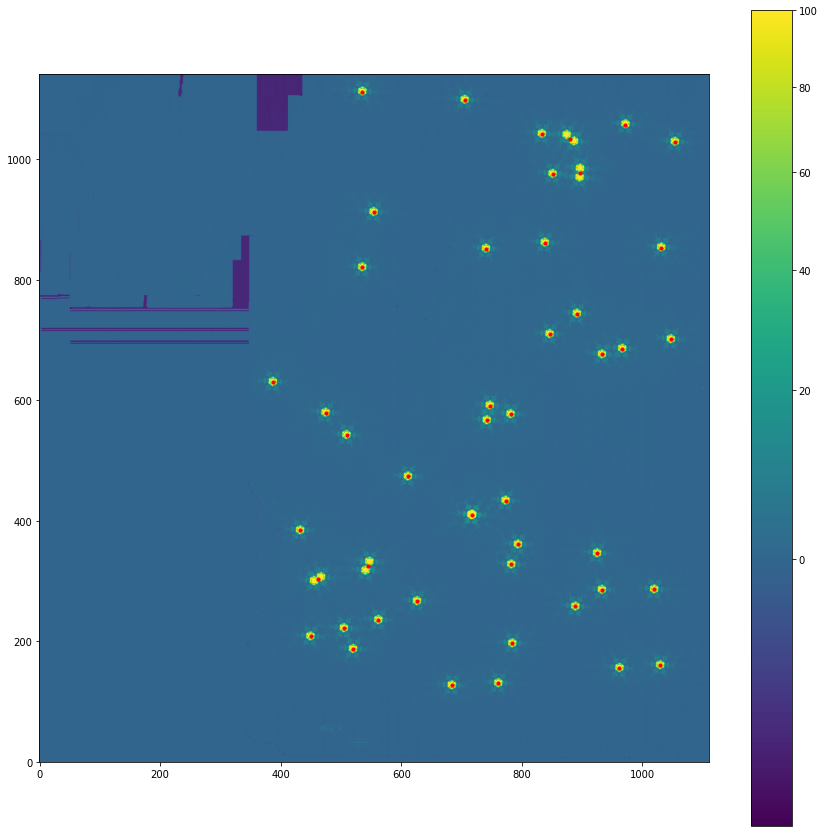

In [10]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table
from matplotlib.colors import LogNorm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

viz1 = LogStretch()
viz2 = LogStretch() + ManualInterval(-12,100)
norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

plt.figure(figsize=(15,15))
#plt.imshow(viz2(im_i2d.data),cmap='gray')
plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-12, vmax=100)
plt.colorbar()
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')



### Check over source catalog match
If the red dots marking sources found in image above are centered on the point sources, the test passes.

### Check DQ Flagging of outlier detection 
Read in the individual crf files which are output from outlier_detection and check the dq extension to see how many pixels out of each image are flagged as outliers.

In [11]:
# Read in each crf file output from outlier_detection and see percentage of pixels flagged as outlier
outlierfiles = glob.glob('starfield*_crf.fits')

flag_thresh = 1.0  # Percentage above which user should be notified of high percentage of flagged pixels

for crffile in outlierfiles: 
    file = ImageModel(crffile)
    nx = file.meta.subarray.xsize
    ny = file.meta.subarray.ysize
    filename = file.meta.filename
    print(filename)

    numpix = nx * ny
    
    # Test that all pixels flagged with OUTLIER are also flagged as DO_NOT_USE
    outlierarray = (file.dq & dqflags.pixel['OUTLIER'] > 0)
    badarray = (file.dq & dqflags.pixel['DO_NOT_USE'] > 0)
    assert outlierarray.all() == badarray.all()
    
    # Count number of pixels flagged as OUTLIER
    jumpcount = (file.dq & dqflags.pixel['OUTLIER'] > 0).sum()
    print('There are ', jumpcount, ' pixels flagged as outliers.')
    #print('Value of dq flag for pixel 784, 672: ', file.dq[672, 784])

    percentflagged = (jumpcount / numpix) * 100.

    print('The percentage of pixels flagged is ', percentflagged)
    if percentflagged > flag_thresh:
        print('This percentage is higher than it should be. Review data through outlier step')
    print('\n')    


starfield_50star4ptdither_combined_0_a3001_crf.fits
There are  2917  pixels flagged as outliers.
The percentage of pixels flagged is  0.27603031128875966


starfield_50star4ptdither_combined_1_a3001_crf.fits
There are  2908  pixels flagged as outliers.
The percentage of pixels flagged is  0.2751786579457364




starfield_50star4ptdither_combined_2_a3001_crf.fits
There are  5751  pixels flagged as outliers.
The percentage of pixels flagged is  0.5442064861918605


starfield_50star4ptdither_combined_3_a3001_crf.fits
There are  5917  pixels flagged as outliers.
The percentage of pixels flagged is  0.5599147589631783




starfield_50star4ptdither_combined_4_a3001_crf.fits
There are  5172  pixels flagged as outliers.
The percentage of pixels flagged is  0.4894167877906977


starfield_50star4ptdither_combined_5_a3001_crf.fits
There are  5164  pixels flagged as outliers.
The percentage of pixels flagged is  0.48865976259689925




starfield_50star4ptdither_combined_6_a3001_crf.fits
There are  7433  pixels flagged as outliers.
The percentage of pixels flagged is  0.7033710331879846


starfield_50star4ptdither_combined_7_a3001_crf.fits
There are  7412  pixels flagged as outliers.
The percentage of pixels flagged is  0.7013838420542636




The output above should show percentages below some chosen threshold. If the percentage of pixels flagged as outliers are above the set threshold, there will be error messages printed. If no error messages are printed, this test is presumed to pass.

<a id="about_ID"></a>
## About this Notebook
**Author:** Misty Cracraft, Senior Staff Scientist, MIRI Branch
<br>**Updated On:** 02/17/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 